In [1]:
from stereo_calibration.rectify import rectify_imgs, make_disparity_map, get_closest_distance
from image_rec.img_rec import ImgRec
from image_rec.stereoImgRec import create_detection_image, calculate_object_distances
import cv2
from random import random
from matplotlib import pyplot as plt
import numpy as np

### File Distance Map Creation

In [2]:
INPUT_DIR = 'data/stereo_images/TEST'
CALIBRATION_DIR = 'data/stereo_images/scenes/calibration_results'
BASELINE = 0.06
DISTANCE_FACTOR = BASELINE * 5/8 # (25 / 39)

Processing data/stereo_images/TEST/raw/8.png


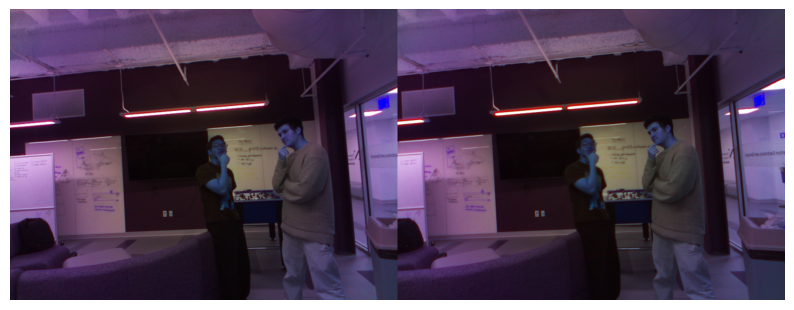

In [3]:
file_num = int(random() * 10) + 1
selected_file = f'{INPUT_DIR}/raw/{file_num}.png'
print(f'Processing {selected_file}')
image = cv2.imread(selected_file)

plt.imshow(image)
plt.axis('off')  # Hide axes
plt.gcf().set_size_inches(10, 10)  # Set the figure size to make the image larger
plt.show()

In [4]:
left = cv2.imread(f'{INPUT_DIR}/left/{file_num}.png')
right = cv2.imread(f'{INPUT_DIR}/right/{file_num}.png')

In [5]:
if left is not None and right is not None:
	left_rectified, right_rectified, Q, focal_length = rectify_imgs(left, right, CALIBRATION_DIR)
else:
	print("Error: One or both of the images are not loaded correctly.")

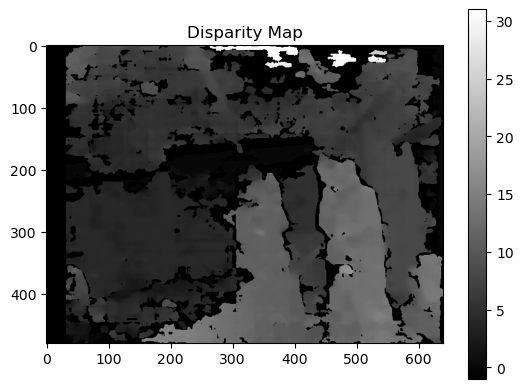

In [6]:
min_disp = 0
num_disp = 16 * 2
block_size = 10
disparity_map = make_disparity_map(left_rectified, right_rectified, min_disp, num_disp, block_size)

# Display disparity map
plt.imshow(disparity_map, 'gray')
plt.title("Disparity Map")
plt.colorbar()
plt.show()


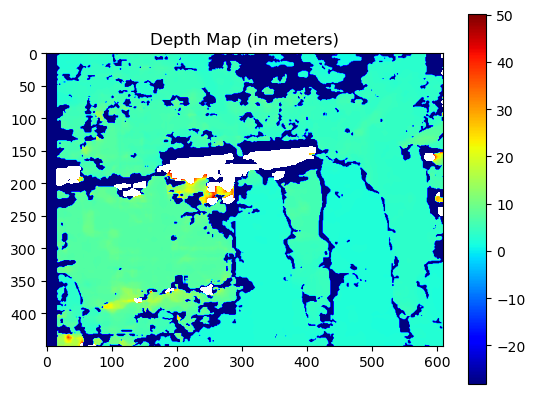

In [7]:
# Step 4: Convert Disparity Map to Depth Map
depth_map = cv2.reprojectImageTo3D(disparity_map, Q)

# Ignore corners and edges of the image
BORDER = 15

# Ensure valid cropping dimensions
height, width = depth_map.shape[:2]
if height > 2 * BORDER and width > 2 * BORDER:
    depth_map = depth_map[BORDER:height - BORDER, BORDER:width - BORDER]
else:
    print("Warning: Border cropping exceeds depth map dimensions, skipping cropping.")

# Extract the Z-values (depth) from the depth map and apply distance factor
distances = depth_map[:, :, 2] * DISTANCE_FACTOR

# Display the Depth Map
fig, ax = plt.subplots()
depth_display = ax.imshow(distances, 'jet')  # Z values represent the depth
plt.colorbar(depth_display)
plt.title("Depth Map (in meters)")
plt.show()


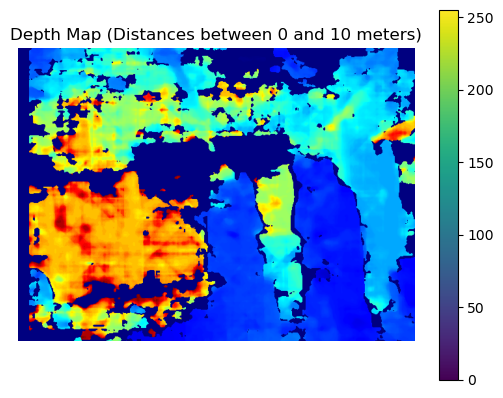

In [8]:
# Define threshold range
MIN_THRESH = 0
MAX_THRESH = 10

# Create a masked version of distances between MIN_THRESH and MAX_THRESH
masked_distances = np.where((distances >= MIN_THRESH) & (distances <= MAX_THRESH), distances, np.nan)

# Normalize the depth values within the threshold range for display purposes
valid_mask = np.isfinite(masked_distances)  # Mask to find valid (non-NaN) values
if np.sum(valid_mask) > 0:
    # Normalize only valid values within the range
    min_valid = np.nanmin(masked_distances)
    max_valid = np.nanmax(masked_distances)
    depth_map_normalized = np.zeros_like(masked_distances)
    
    # Apply normalization only to the valid range
    depth_map_normalized[valid_mask] = 255 * (masked_distances[valid_mask] - min_valid) / (max_valid - min_valid)
    depth_map_normalized = depth_map_normalized.astype(np.uint8)

    # Apply a colormap for better visualization
    depth_map_colored = cv2.applyColorMap(depth_map_normalized, cv2.COLORMAP_JET)
    depth_map_colored = cv2.cvtColor(depth_map_colored, cv2.COLOR_BGR2RGB)

    # Display the Depth Map for the specified threshold range
    fig, ax = plt.subplots()
    depth_display = ax.imshow(depth_map_colored)
    plt.colorbar(depth_display)
    plt.title(f"Depth Map (Distances between {MIN_THRESH} and {MAX_THRESH} meters)")
    plt.axis('off')
    plt.show()
else:
    print(f"No values found within the threshold range [{MIN_THRESH}, {MAX_THRESH}] meters.")

### Closest Object Distance


In [9]:
closest_distance, closest_coordinates = get_closest_distance(distances)
if closest_distance is not None and closest_coordinates is not None:
    print(f'Closest distance: {closest_distance:.2f} meters at coordinates {closest_coordinates}')
else:
    print('No valid distances found.')

Closest distance: 1.61 meters at coordinates (np.int64(346), np.int64(473))


Closest distance: 1.61 meters at coordinates (np.int64(346), np.int64(473))


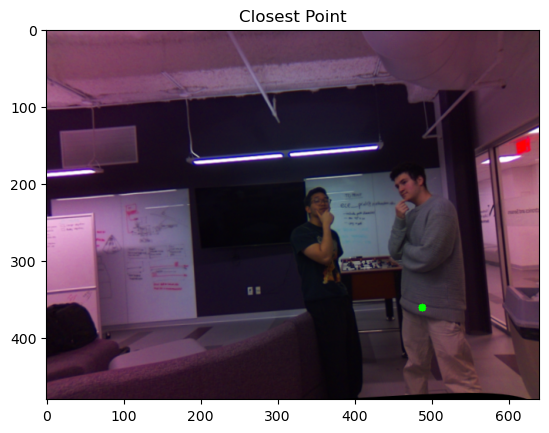

In [10]:

if closest_distance is not None and closest_coordinates is not None:
    print(f'Closest distance: {closest_distance:.2f} meters at coordinates {closest_coordinates}')
    
    # Adjust coordinates for display purposes, since they are affected by cropping
    adjusted_coordinates = (closest_coordinates[0] + BORDER, closest_coordinates[1] + BORDER)

    # Draw the closest point on the original left rectified image
    closest_image = left_rectified.copy()
    cv2.circle(closest_image, adjusted_coordinates[::-1], 5, (0, 255, 0), -1)
    plt.imshow(cv2.cvtColor(closest_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper color display with matplotlib
    plt.title("Closest Point")
    plt.show()


### Getting the distances of detected objects

In [11]:
# Image Recognition
img_rec = ImgRec()

In [12]:
# Detections on left rectified image
detected_objects = img_rec.predict_frame(left_rectified)
print('OBJECTS')
print(detected_objects)


0: 480x640 2 persons, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
OBJECTS
[('person', tensor([[444.1212, 172.6904, 564.7686, 471.2339]]), 0.8909054398536682), ('person', tensor([[316.0599, 203.2693, 413.4045, 479.1117]]), 0.8849502205848694)]


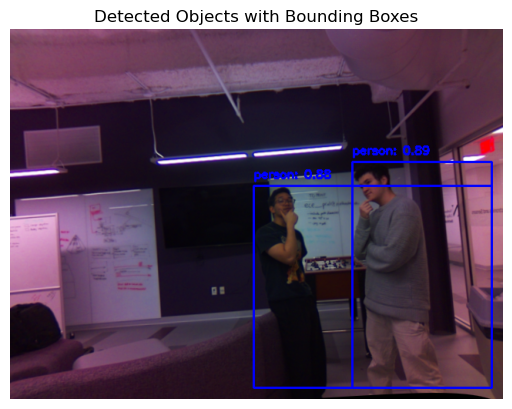

In [13]:
output_image = create_detection_image(left_rectified.copy(), detected_objects, BORDER)

# Display the image with bounding boxes
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper color display with matplotlib
plt.title("Detected Objects with Bounding Boxes")
plt.axis('off')
plt.show()


In [14]:
object_distances = calculate_object_distances(distances, detected_objects, BORDER)

In [15]:
print('OBJECT DISTANCES')
print(object_distances)

OBJECT DISTANCES
[('person', np.float32(2.175529)), ('person', np.float32(2.2629876))]
